In [1]:
%load_ext autoreload
%autoreload 2

In [105]:
LOG_PATH="/Users/law/repos/ma/disco/benchmark-runs/runs_sustainable_throughput/tumbling_1000_max/"

In [111]:
import os
import re

RUN_RE = re.compile(r"Running (\d+) child.*, (\d+) stream.*")
THROUGHPUT_RE = re.compile(r"Found sustainable candidate \((\d+) events/s.\)*")

def parse_log_file(log_file):
    sustainable_throughputs= {}
    
    current_run = None
    current_throughput = None
    with open(log_file) as f:
        for line in f:
            run_match = RUN_RE.match(line)
            if run_match is not None:
                if current_run != None:
                    print(f"Did not find candidate line for {current_run}")
                current_run = (int(run_match.group(1)), int(run_match.group(2)))
                current_throughput = None

            throughput_match = THROUGHPUT_RE.match(line)
            if throughput_match is not None:
                if current_throughput is not None:
                    print(f"Did not find run line after {current_run}")
                current_throughput = int(throughput_match.group(1))
                sustainable_throughputs[current_run] = current_throughput
                current_run = None
                
    if current_run is not None:
        print(f"Did not find candidate line for {current_run}")
                
    return sustainable_throughputs
                

ALL_THROUGHPUTS = {}
for log_file in sorted(os.listdir(LOG_PATH)):
    if log_file.endswith("-nodes-max.log"):
        print(f"Parsing {log_file}")
        sustainable_throughputs = parse_log_file(os.path.join(LOG_PATH, log_file))
        print(f"current: {sustainable_throughputs}")
        ALL_THROUGHPUTS = {**ALL_THROUGHPUTS, **sustainable_throughputs}
        print(f"all:     {ALL_THROUGHPUTS}\n")        

Parsing sustainable_run_2019-08-30-1013-1to8-children-1to16-nodes-max.log
current: {(1, 1): 968750, (1, 2): 921875, (1, 4): 453125, (1, 8): 234375, (2, 2): 1179687, (2, 4): 765625, (4, 4): 1171875, (4, 8): 734375, (8, 8): 1156250, (8, 16): 726562}
all:     {(1, 1): 968750, (1, 2): 921875, (1, 4): 453125, (1, 8): 234375, (2, 2): 1179687, (2, 4): 765625, (4, 4): 1171875, (4, 8): 734375, (8, 8): 1156250, (8, 16): 726562}

Parsing sustainable_run_2019-09-03-0943-1to8-children-1to16-nodes-max.log
Did not find candidate line for (8, 8)
current: {(1, 1): 1054687, (1, 2): 664062, (1, 4): 343750, (1, 8): 164062, (2, 2): 1085937, (2, 4): 601562, (4, 4): 1070312, (4, 8): 695312}
all:     {(1, 1): 1054687, (1, 2): 664062, (1, 4): 343750, (1, 8): 164062, (2, 2): 1085937, (2, 4): 601562, (4, 4): 1070312, (4, 8): 695312, (8, 8): 1156250, (8, 16): 726562}



In [112]:
for (num_children, num_streams), throughput in sorted(ALL_THROUGHPUTS.items()):
    print(f"Total sustainable throughput for {num_children} child(ren) with " \
          f"{num_streams // num_children} stream(s) each " \
          f"is {(throughput * num_streams // num_children): >7d} events/s per child.")

Total sustainable throughput for 1 child(ren) with 1 stream(s) each is 1054687 events/s per child.
Total sustainable throughput for 1 child(ren) with 2 stream(s) each is 1328124 events/s per child.
Total sustainable throughput for 1 child(ren) with 4 stream(s) each is 1375000 events/s per child.
Total sustainable throughput for 1 child(ren) with 8 stream(s) each is 1312496 events/s per child.
Total sustainable throughput for 2 child(ren) with 1 stream(s) each is 1085937 events/s per child.
Total sustainable throughput for 2 child(ren) with 2 stream(s) each is 1203124 events/s per child.
Total sustainable throughput for 4 child(ren) with 1 stream(s) each is 1070312 events/s per child.
Total sustainable throughput for 4 child(ren) with 2 stream(s) each is 1390624 events/s per child.
Total sustainable throughput for 8 child(ren) with 1 stream(s) each is 1156250 events/s per child.
Total sustainable throughput for 8 child(ren) with 2 stream(s) each is 1453124 events/s per child.


# Plots

In [113]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True, 'pgf.rcfonts' : False})

### Plot Sustainable Throughput

[(1, 1.054687), (2, 1.328124), (4, 1.375), (8, 1.312496)]
(1, 2, 4, 8) (1.054687, 1.328124, 1.375, 1.312496)


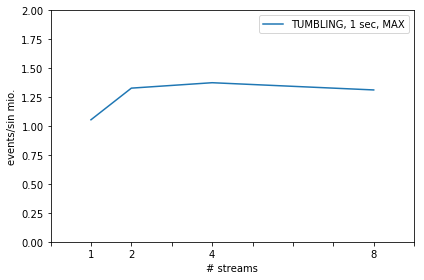

In [114]:
import matplotlib.pyplot as plt

streams = sorted([(n_stream, (n_stream * throughput) / 1_000_000 ) 
                  for ((n_child, n_stream), throughput) 
                  in ALL_THROUGHPUTS.items() 
                  if n_child == 1])
print(streams)

streams, throughputs = list(zip(*streams))

print(streams, throughputs)

plt.plot(streams, throughputs)
plt.ylabel("events/sin mio.")
plt.xlabel("# streams")
plt.xticks(range(10), ["", "1", "2", "", "4", "", "", "", "8", ""])
plt.ylim(ymin=0, ymax=2)
plt.legend(["TUMBLING, 1 sec, MAX"])
plt.show()

# if save_fig:
#     plt.savefig(f"load_{out_file_name}.svg")
#     plt.savefig(f"load_{out_file_name}.pgf")
#     plt.savefig(f"load_{out_file_name}.png")
# plt.show()

[((1, 1), 1.054687), ((1, 2), 1.328124), ((2, 2), 2.171874), ((2, 4), 2.406248), ((4, 4), 4.281248), ((4, 8), 5.562496), ((8, 8), 9.25), ((8, 16), 11.624992)]
((1, 1), (1, 2), (2, 2), (2, 4), (4, 4), (4, 8), (8, 8), (8, 16)) (1.054687, 1.328124, 2.171874, 2.406248, 4.281248, 5.562496, 9.25, 11.624992)


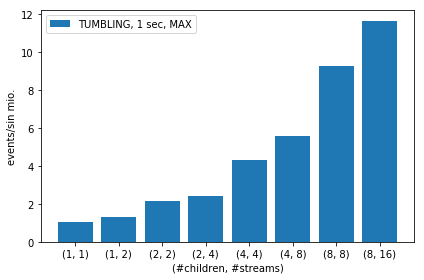

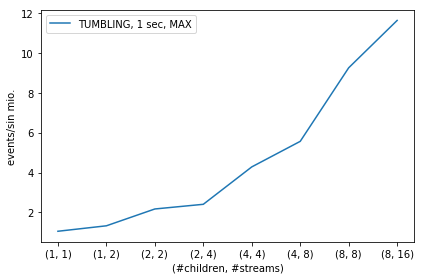

In [115]:
import matplotlib.pyplot as plt

streams = sorted([((n_child, n_stream), (n_stream * throughput) / 1_000_000 ) 
                  for ((n_child, n_stream), throughput) 
                  in ALL_THROUGHPUTS.items() 
                  if n_child == n_stream or n_child * 2 == n_stream])

print(streams)

streams, throughputs = list(zip(*streams))

print(streams, throughputs)

plt.bar(range(len(throughputs)), throughputs)
plt.ylabel("events/sin mio.")
plt.xlabel("(#children, #streams)")
plt.xticks(range(len(streams)), [f"({n_child}, {n_stream})" for n_child, n_stream in streams])
plt.legend(["TUMBLING, 1 sec, MAX"])
plt.show()

plt.plot(throughputs)
plt.ylabel("events/sin mio.")
plt.xlabel("(#children, #streams)")
plt.xticks(range(len(streams)), [f"({n_child}, {n_stream})" for n_child, n_stream in streams])
plt.legend(["TUMBLING, 1 sec, MAX"])
plt.show()
